# Distribution of Unccertainty for Columbia Forecast
The goal of this notebook is to examine the empirical distribution of the uncertainty set for the Columbia admitted patients forecast.

In [1]:
using CSV, DataFrames
using Gadfly
using Statistics
using Distributions
using Loess
using LsqFit

In [2]:
col_dict = Dict(
    "hosp_new_1" => 1,
    "hosp_new_2point5" => 2.5,
    "hosp_new_5" => 5,
    "hosp_new_10" => 10,
    "hosp_new_15" => 15,
    "hosp_new_20" => 20,
    "hosp_new_25" => 25,
    "hosp_new_30" => 30,
    "hosp_new_35" => 35,
    "hosp_new_40" => 40,
    "hosp_new_45" => 45,
    "hosp_new_50" => 50,
    "hosp_new_55" => 55,
    "hosp_new_60" => 60,
    "hosp_new_65" => 65,
    "hosp_new_70" => 70,
    "hosp_new_75" => 75,
    "hosp_new_80" => 80,
    "hosp_new_85" => 85,
    "hosp_new_90" => 90,
    "hosp_new_95" => 95,
    "hosp_new_97point5" => 97.5,
    "hosp_new_99" => 99,
);
col_names = sort(collect(keys(col_dict)), by=k->col_dict[k])
col_vals = sort(collect(values(col_dict)));
val_to_col = Dict(v => i for (i,v) in enumerate(col_vals));
p_vals = col_vals ./ 100;

In [3]:
forecast = CSV.read("../../data/forecasts/columbia/2020-05-31/state_cdchosp_80contactw5p.csv")
rename!(forecast, map(x -> strip(string(x)), names(forecast)))
forecast_data = Matrix(forecast[:,col_names]);

## Averaged Distribution over all States, Days

In [4]:
fc1 = forecast_data .- forecast_data[:,val_to_col[50]]
fc2 = max.(abs.(fc1[:,val_to_col[1]]), abs.(fc1[:,val_to_col[99]]))
fc3 = max.(1, fc2)
fc4 = fc1 ./ fc3
fc5 = mean(fc4, dims=1)[:]
fc7 = (p_vals[2:end] - p_vals[1:end-1]) ./ (fc5[2:end] - fc5[1:end-1])
fc8 = fc7 / sum(fc7);

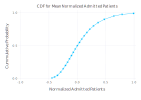

In [5]:
Gadfly.plot(
    y=p_vals, x=fc5,
    Geom.point, Geom.line,
    Scale.x_continuous(minvalue=-1, maxvalue=1),
    Guide.title("CDF for Mean Normalized Admitted Patients"),
    Guide.ylabel("Cummulative Probability"),
    Guide.xlabel("Normalized Admitted Patients"),
) |> SVG()

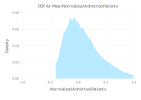

In [6]:
plt = Gadfly.plot(
    x=fc5[2:end], y=fc8, ymax=fc8, ymin=fill(0.0, length(fc8)),
    Geom.ribbon, Geom.line,
    Scale.x_continuous(minvalue=-1, maxvalue=1),
    Guide.title("PDF for Mean Normalized Admitted Patients"),
    Guide.ylabel("Density"),
    Guide.xlabel("Normalized Admitted Patients"),
) |> SVG()

## Distribution for Example (State, Day) Pair

In [7]:
state = "New York"
date = "05/31/2020"
idx = findfirst(row -> row.location == state && row.Date == date, eachrow(forecast));

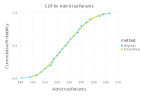

In [8]:
model = loess(Float64.(forecast_data[idx,:]), p_vals)
vs = predict(model, collect(300.0:360.0))
df_fit = DataFrame(x=collect(300.0:360.0), y=vs, method="Smoothed")
df_real = DataFrame(y=p_vals, x=forecast_data[idx,:], method="Original")
df = vcat(df_real, df_fit)
plt = Gadfly.plot(
    df, x=:x, y=:y, color=:method,
    Scale.color_discrete, Geom.point, Geom.line,
    Guide.title("CDF for Admitted Patients"),
    Guide.ylabel("Cummulative Probability"),
    Guide.xlabel("Admitted Patients"),
)
plt |> SVG()

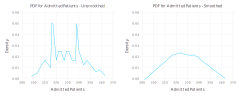

In [9]:
d0 = forecast_data[idx,:]
d1 = (p_vals[2:end] - p_vals[1:end-1]) ./ (d0[2:end] - d0[1:end-1])
d2 = [0; deepcopy(d1); 0;]
for (i,v) in enumerate(d2)
    if v == Inf
        for j in i:length(d2)
            if d2[j] != Inf
                d2[i] = (d2[i-1] + d2[j]) / 2
                break
            end
        end
    end
end
d2 = d2[2:end-1]
plt1 = Gadfly.plot(
    x=d0[2:end], y=d2,
    Geom.line,
    Guide.title("PDF for Admitted Patients - Unsmoothed"),
    Guide.ylabel("Density"),
    Guide.xlabel("Admitted Patients"),
    Coord.cartesian(ymin=0.0, ymax=0.06),
)

z = Float64.(forecast_data[idx,:])
model = loess(z, p_vals)
lb, ub = floor(minimum(z)), ceil(maximum(z))
d0 = collect(lb:1.0:ub)
d1 = predict(model, d0)
q = (d1[2:end] - d1[1:end-1]) ./ (d0[2:end] - d0[1:end-1])
plt2 = Gadfly.plot(
    x=d0[2:end], y=q,
    Geom.line,
    Guide.title("PDF for Admitted Patients - Smoothed"),
    Guide.ylabel("Density"),
    Guide.xlabel("Admitted Patients"),
    Coord.cartesian(ymin=0.0, ymax=0.06),
)

plt = hstack(plt1, plt2)
plt |> SVG(24cm, 10cm)

(μ, σ) = (327, 17)

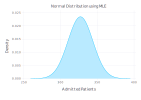

In [10]:
μ = forecast_data[idx,val_to_col[50]]
σ = forecast_data[idx,val_to_col[85]] - μ

@show (μ, σ)

dist = Normal(μ, σ)

xvals = collect(floor(μ-4σ):1:ceil(μ+4σ))
yvals = Float32.(pdf.(dist, xvals))

plt = Gadfly.plot(
    x=xvals, y=yvals, ymin=fill(0.0, length(yvals)), ymax=yvals,
    Geom.line, Geom.ribbon,
    Guide.ylabel("Density"), Guide.xlabel("Admitted Patients"),
    Guide.title("Normal Distribution using MLE"),
)
plt |> SVG()

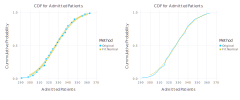

In [11]:
model = loess(Float64.(forecast_data[idx,:]), p_vals)
vs = predict(model, collect(300.0:360.0))

df_real = DataFrame(y=p_vals, x=forecast_data[idx,:], Method="Original")
df_fit = DataFrame(x=collect(300.0:360.0), y=cdf.(dist, collect(300.0:360.0)), Method="Fit Normal")
df = vcat(df_real, df_fit)

plt_point = Gadfly.plot(
    df, x=:x, y=:y, color=:Method,
    Geom.point, Geom.line, Scale.color_discrete,
    Guide.title("CDF for Admitted Patients"),
    Guide.ylabel("Cummulative Probability"),
    Guide.xlabel("Admitted Patients"),
)
plt_line = Gadfly.plot(
    df, x=:x, y=:y, color=:Method,
    Scale.color_discrete, Geom.line,
    Guide.title("CDF for Admitted Patients"),
    Guide.ylabel("Cummulative Probability"),
    Guide.xlabel("Admitted Patients"),
)

plt = hstack(plt_point, plt_line)
plt |> SVG(24cm, 10cm)